# Grammar improvement evaluation

## Includes: 
- 5 Models: standard finetuning, 3layer finetuning, only 3 Layers TR, only 6 Layers TR, Full model TR
- Grammar stats 


1. Grammar stats of the untrained GPT2 model (baseline)
    
2. Grammar stats for classic finetuning

3. Grammar stats for Translation models


    
### Explanations: 

#### Datasets:
    - Format: Sentence=Translation Sentence=Translation<|endoftext|>   
    - All datasets are split on EOS tokens. 
    - All datasets exclude sentences with over 100 mistakes ---> trash filter
    - Sentence pair --> Sentence=Translation
    - train: a sample of the training data (700 characters for one sentence pair max. This filter is active on the real training data aswell)
    - test_700: testing data with a max length of a 700 characters for one sentence pair
    - test_long: testing data with no max length (In the wild data)
    - test_nf_lrong: testing data which includes correct sentences also and has no max length filter
    - test_nf_700: testing data which includes correct sentences also and with a max length of 700 characters per sentence pair
    
    
#### Grammar_stats:
    - Basically Error rates per Token, can be grouped in specific mistakes if needed
    

### Observations:

- The number of layers is pretty much linear correlated with the performance of the model. 
- While all models work, it seems like we need the full model after all for the maximum performance...

In [1]:
# Set the GPU for training
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import pickle
#from transformers import GPT2Tokenizer, GPT2LMHeadModel, modeling_utils, GPT2Config, modeling_gpt2, GPT2Model, GPT2PreTrainedModel, GPT2Config
import copy
import operator
import json
import numpy as np
import pandas as pd
import language_check
from functools import reduce
import difflib
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
from utility import *

In [3]:
titles = ["Number of sentences", "Number of wrong sentences", "Number of Mistakes", "Number of tokens",
          "Errors per Token","Error per sentence","trashFilter"]

### Calculate Base

In [4]:
correct_base_test()

### Calculate TrModels

In [5]:
data = load_datasets()
trans = load_data()

In [6]:
correct_data(trans)

3train
3test_all_wrong_700
3test_all_wrong_long
3test_no_filter_long
3test_no_filter_700
6train
6test_all_wrong_700
6test_all_wrong_long
6test_no_filter_long
6test_no_filter_700
fulltrain
fulltest_all_wrong_700
fulltest_all_wrong_long
fulltest_no_filter_long
fulltest_no_filter_700


### Calculate Tr generation

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [5]:
b = load_and_split_finetune("generated/transgen/generation/")

In [6]:
condition = "The Technology Report empowers or enlightens. ==== The Technology Report empowers or enlightens."

In [7]:
b = b[0] + b[1]

In [ ]:
%%capture
predictions = []
for x in b: 
    inp = condition + " " + x + "===="
    inp = tokenizer.encode(inp) 
    predictions.append(generation(model,tokenizer,inp))
    
pickle.dump(predictions,open("saves/transgen.p","wb"))

In [30]:
pickle.dump([b[0] + b[1]],open("saves/transgen.p", "wb") )

### Calculate classic finetune

In [6]:
data2 = load_and_split_finetune()

In [8]:
%%capture
correct_model_dataset(data2,"classic_finetuning")

In [4]:
data3 = load_and_split_finetune("generated/classic_3/")

In [5]:
correct_model_dataset(data3,"classic_finetuning_3")

In [11]:
#  script testing testing

In [6]:
data2 = load_and_split_finetune("generated/test/")

In [6]:
data3 = load_and_split_finetune("generated/test_2/")

In [7]:
%%capture
correct_model_dataset(data2,"classic_finetuning_testing")

In [7]:
%%capture
correct_model_dataset(data3,"classic_finetuning_testing_2")

# Vanilla GPT2 error rate (thats the baseline) 

In [53]:
out  = load_base()

In [54]:
pd.DataFrame(out,index=titles,columns =["GPT2 base"]) # test data

,GPT2 base
Number of sentences,1.031040e+05
Number of wrong sentences,6.109900e+04
Number of Mistakes,1.927430e+05
Number of tokens,3.421295e+06
Errors per Token,5.633627e-02
Error per sentence,1.869404e+00
trashFilter,2.300000e+01


In [55]:
# Exact stats

In [8]:
corrected = pickle.load(open("saves/base_translation_test.p","rb"))
stats = pickle.load(open("saves/base_translation_stats_test.p","rb"))

In [57]:
countDic = {}
for x in stats[4]:
    if x[0] + "__" + str(x[1]) in countDic:
        countDic[x[0] + "__" + str(x[1])] +=1
    else: 
        countDic[x[0] + "__" + str(x[1])] = 1


In [58]:
Top = sorted(countDic.items() ,  key=lambda x: x[1])
# Iterate over the sorted sequence

In [59]:
countDic2 = {}
for x in stats[2]:
    if x in countDic2:
        countDic2[x] +=1
    else: 
        countDic2[x] = 1

In [60]:
Top2 = sorted(countDic2.items() ,  key=lambda x: x[1])
# Iterate over the sorted sequence

In [62]:
Top2[-20:]

[('A_INFINITVE', 225),
 ('THE_SUPERLATIVE', 230),
 ('SOME_OF_THE', 251),
 ('HE_VERB_AGR', 299),
 ('POSSESSIVE_APOSTROPHE', 329),
 ('EN_CONTRACTION_SPELLING', 378),
 ('WHITESPACE_RULE', 414),
 ('I_LOWERCASE', 488),
 ('SENT_START_CONJUNCTIVE_LINKING_ADVERB_COMMA', 526),
 ('EN_A_VS_AN', 544),
 ('SENTENCE_FRAGMENT', 632),
 ('DOUBLE_PUNCTUATION', 733),
 ('CD_NN', 772),
 ('ENGLISH_WORD_REPEAT_RULE', 1860),
 ('SENTENCE_WHITESPACE', 1861),
 ('UPPERCASE_SENTENCE_START', 7890),
 ('COMMA_PARENTHESIS_WHITESPACE', 8350),
 ('EN_UNPAIRED_BRACKETS', 12575),
 ('EN_QUOTES', 30551),
 ('MORFOLOGIK_RULE_EN_US', 119448)]

# Translation Model error rate comparison

In [48]:
out = load_grammar()

In [49]:
pd.DataFrame(out["3"][3],columns = titles)

,Number of sentences,Number of wrong sentences,Number of Mistakes,Number of tokens,Errors per Token,Error per sentence,trashFilter
0,1000.0,479.0,1245.0,32574.0,0.038221,1.245,0.0
1,1000.0,473.0,1375.0,33361.0,0.041216,1.375,1.0
2,1000.0,468.0,1174.0,33480.0,0.035066,1.174,0.0
3,1000.0,458.0,1124.0,33306.0,0.033748,1.124,0.0


In [50]:
pd.DataFrame(out["6"][3],columns = titles)

,Number of sentences,Number of wrong sentences,Number of Mistakes,Number of tokens,Errors per Token,Error per sentence,trashFilter
0,1000.0,478.0,1512.0,32384.0,0.046690,1.512,1.0
1,1000.0,451.0,1386.0,33730.0,0.041091,1.386,2.0
2,1000.0,431.0,1330.0,33920.0,0.039210,1.330,2.0
3,1000.0,427.0,1418.0,33799.0,0.041954,1.418,2.0
4,1000.0,422.0,971.0,32155.0,0.030197,0.971,0.0
5,1000.0,416.0,953.0,31367.0,0.030382,0.953,0.0
6,1000.0,407.0,947.0,32096.0,0.029505,0.947,0.0
7,1000.0,401.0,900.0,32066.0,0.028067,0.900,0.0
8,1000.0,401.0,923.0,31508.0,0.029294,0.923,0.0
9,1000.0,395.0,907.0,31478.0,0.028814,0.907,0.0


In [51]:
pd.DataFrame(out["full"][3],columns = titles)

,Number of sentences,Number of wrong sentences,Number of Mistakes,Number of tokens,Errors per Token,Error per sentence,trashFilter
0,1000.0,354.0,845.0,33226.0,0.025432,0.845,1.0
1,1000.0,347.0,695.0,31309.0,0.022198,0.695,0.0
2,1000.0,339.0,674.0,32361.0,0.020828,0.674,0.0
3,1000.0,342.0,676.0,32358.0,0.020891,0.676,0.0


In [ ]:
out = load_grammar()

# Finetune error rate comparison

In [4]:
classic = load_finetune()

In [5]:
pd.DataFrame(classic,columns = titles)

,Number of sentences,Number of wrong sentences,Number of Mistakes,Number of tokens,Errors per Token,Error per sentence,trashFilter
0,1000,359,643,33618,0.019127,0.643,0
1,1000,344,565,32830,0.017210,0.565,0
2,1000,356,668,34024,0.019633,0.668,0
3,1000,366,764,31710,0.024093,0.764,0
4,1000,383,863,36468,0.023665,0.863,0
5,1000,324,673,37077,0.018151,0.673,0
6,1000,329,694,36017,0.019269,0.694,0
7,1000,426,760,27658,0.027478,0.760,0
8,1000,333,793,34810,0.022781,0.793,0
9,1000,314,568,32577,0.017436,0.568,0


In [8]:
classic = load_finetune("saves/classic_finetuning_3")

In [9]:
pd.DataFrame(classic,columns = titles)

,Number of sentences,Number of wrong sentences,Number of Mistakes,Number of tokens,Errors per Token,Error per sentence,trashFilter
0,1000,538,2071,39600,0.052298,2.071000,0
1,1000,523,1746,36820,0.047420,1.746000,0
2,1000,549,1794,36979,0.048514,1.794000,0
3,1000,473,1617,35010,0.046187,1.617000,0
4,1000,516,1579,37786,0.041788,1.579000,0
5,997,527,1480,34717,0.042630,1.484453,3
6,998,495,1810,37264,0.048572,1.813627,2
7,999,531,1791,36067,0.049658,1.792793,1
8,1000,487,1440,33860,0.042528,1.440000,0
9,1000,532,1835,39046,0.046996,1.835000,0


In [9]:
# Testing station: 
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer

In [8]:
classic = load_finetune("saves/classic_finetuning_testing_2")

In [10]:
pd.DataFrame(classic,columns = titles)

,Number of sentences,Number of wrong sentences,Number of Mistakes,Number of tokens,Errors per Token,Error per sentence,trashFilter
0,1000,375,741,32653,0.022693,0.741,0


In [10]:
classic = load_finetune("saves/classic_finetuning_testing")

In [11]:
pd.DataFrame(classic,columns = titles)

,Number of sentences,Number of wrong sentences,Number of Mistakes,Number of tokens,Errors per Token,Error per sentence,trashFilter
0,1000,379,685,33792,0.020271,0.685,0


# Model based grouping:

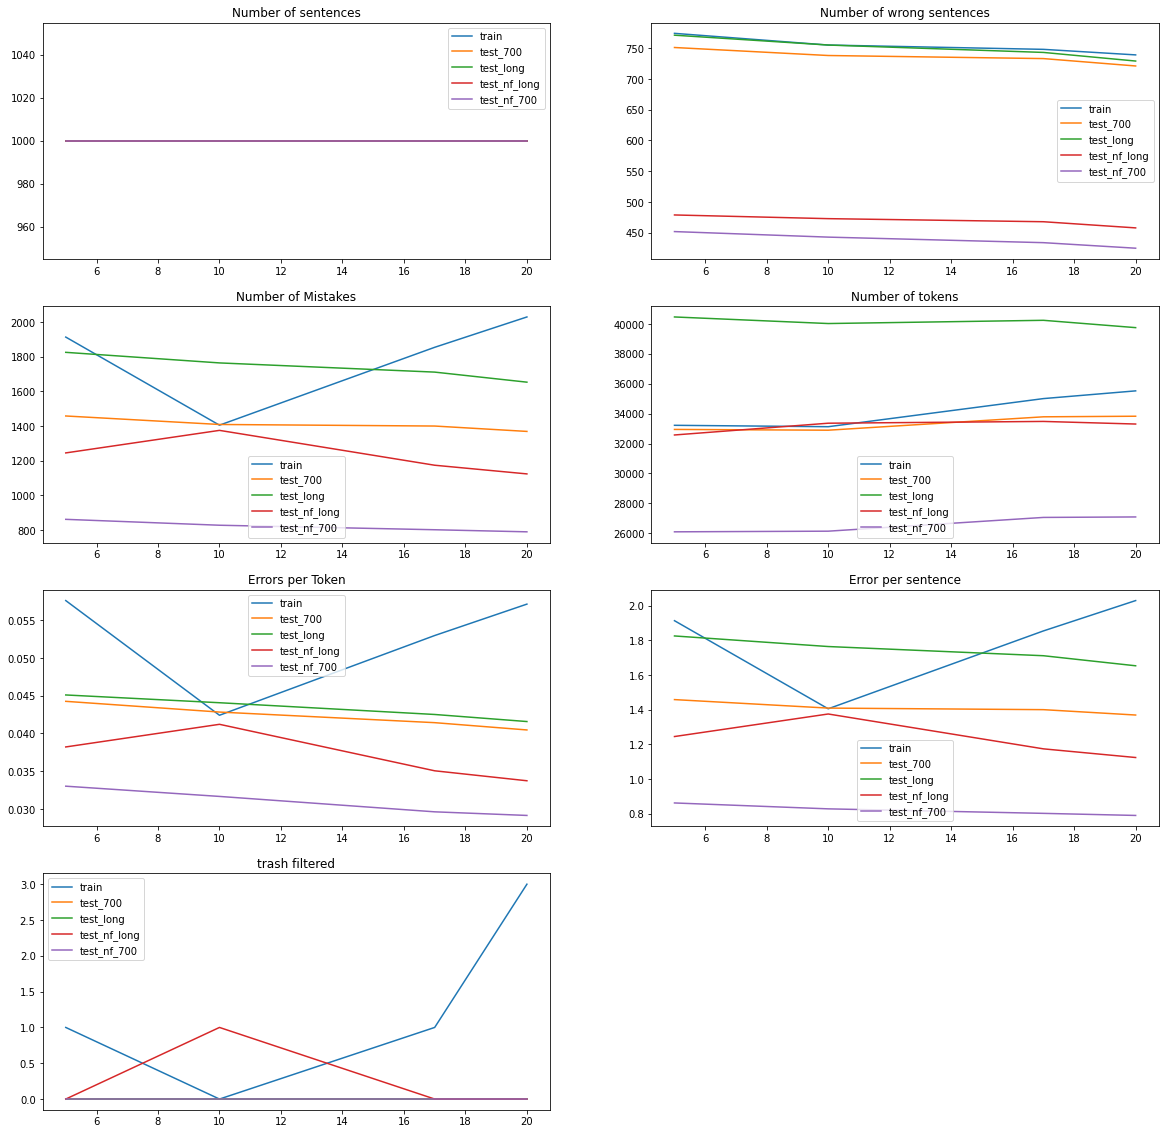

In [55]:
format_reloads_model_2(out,"3")

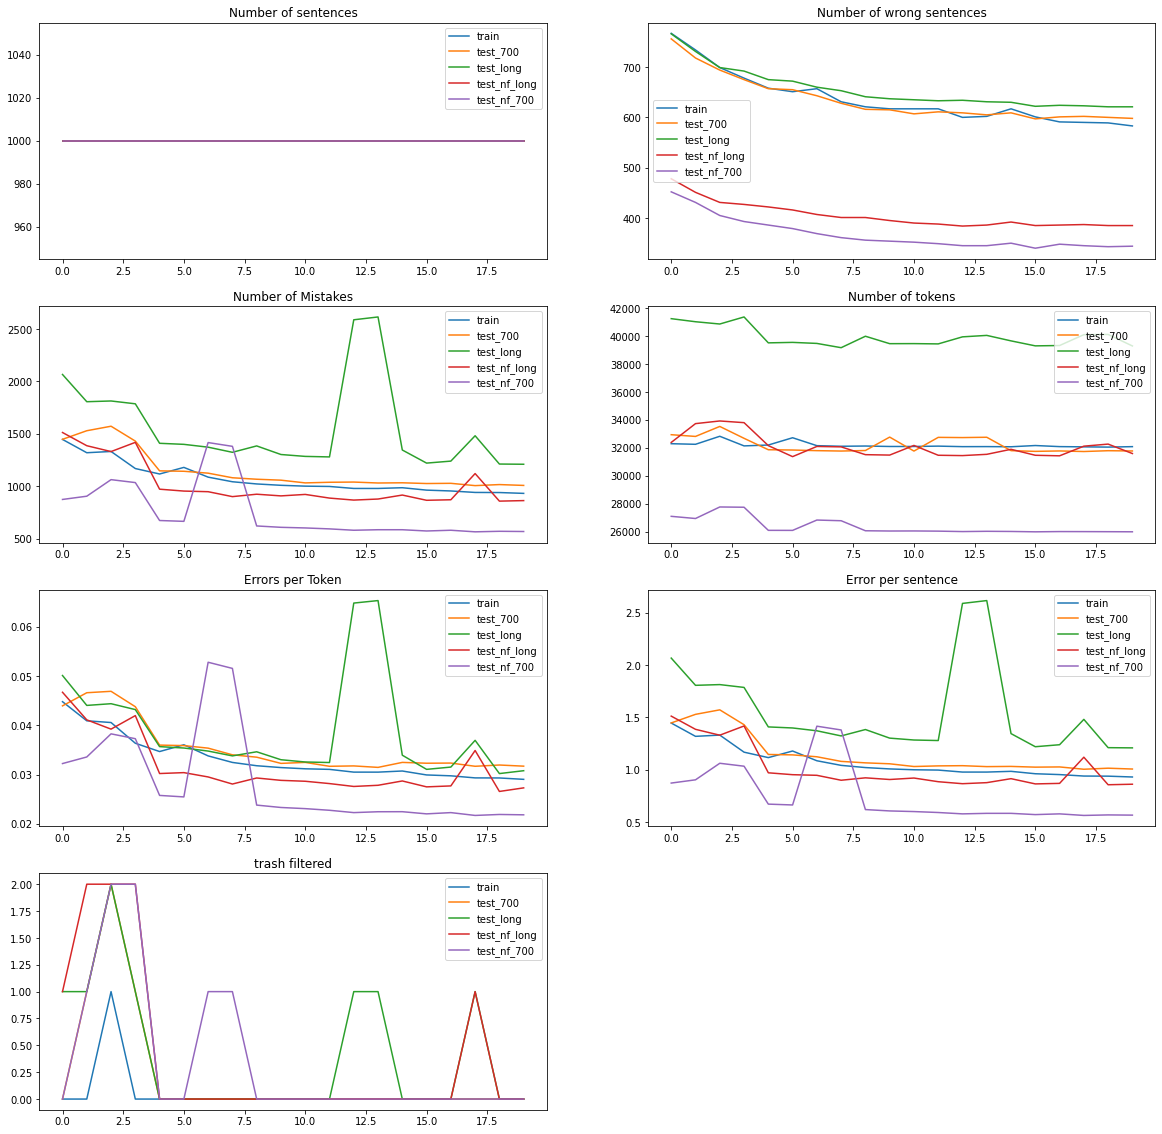

In [56]:
format_reloads_model_2(out,"6")

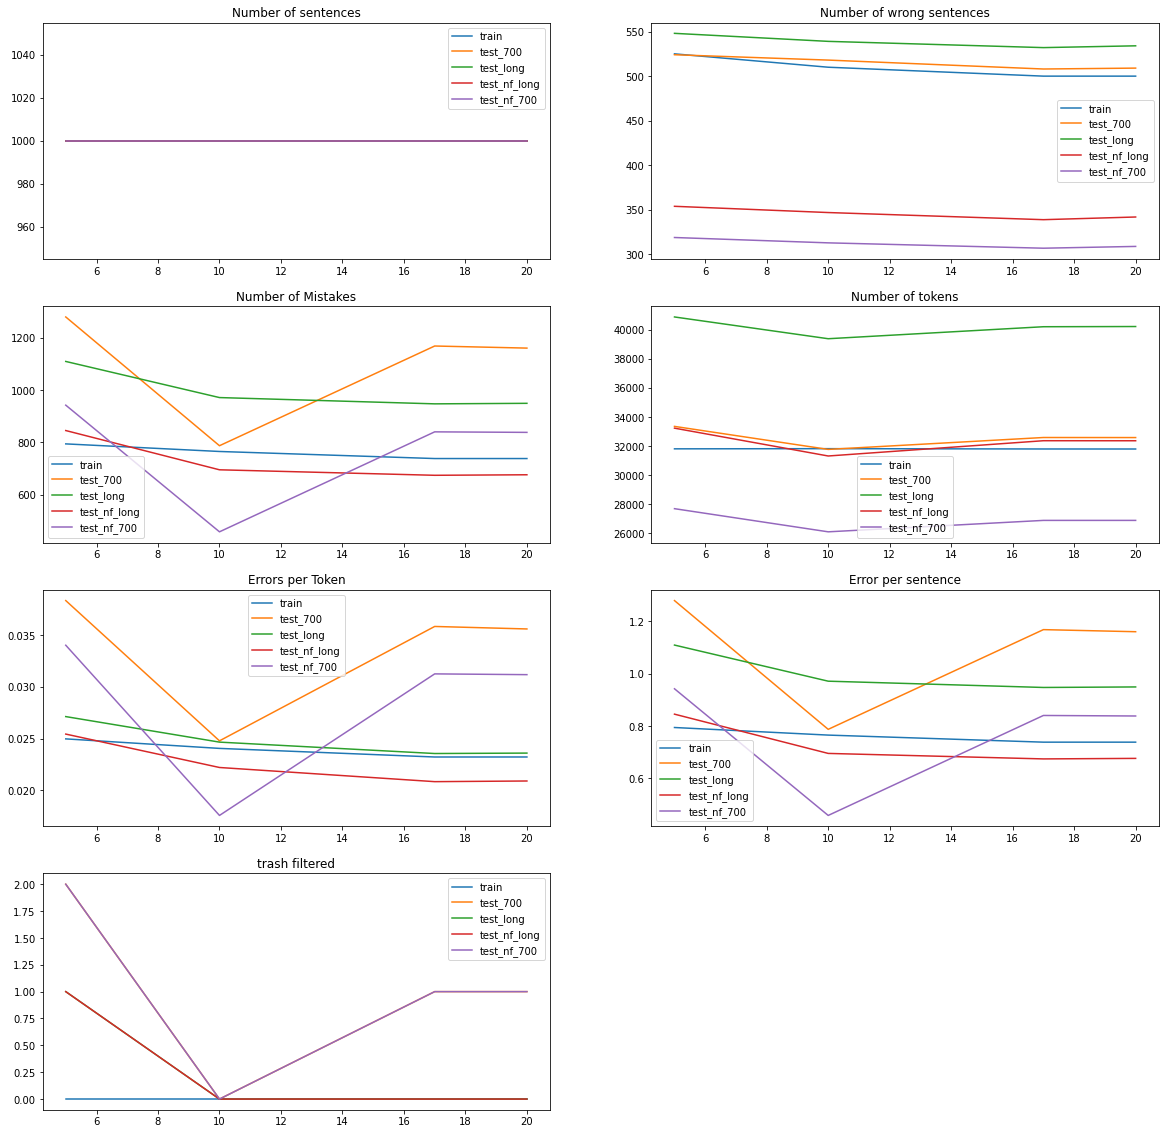

In [57]:
format_reloads_model_2(out,"full")

# Dataset based

    - ids --> ['train','test_all_wrong_700','test_all_wrong_long','test_no_filter_long','test_no_filter_700'] --> 0,1,2,3,4

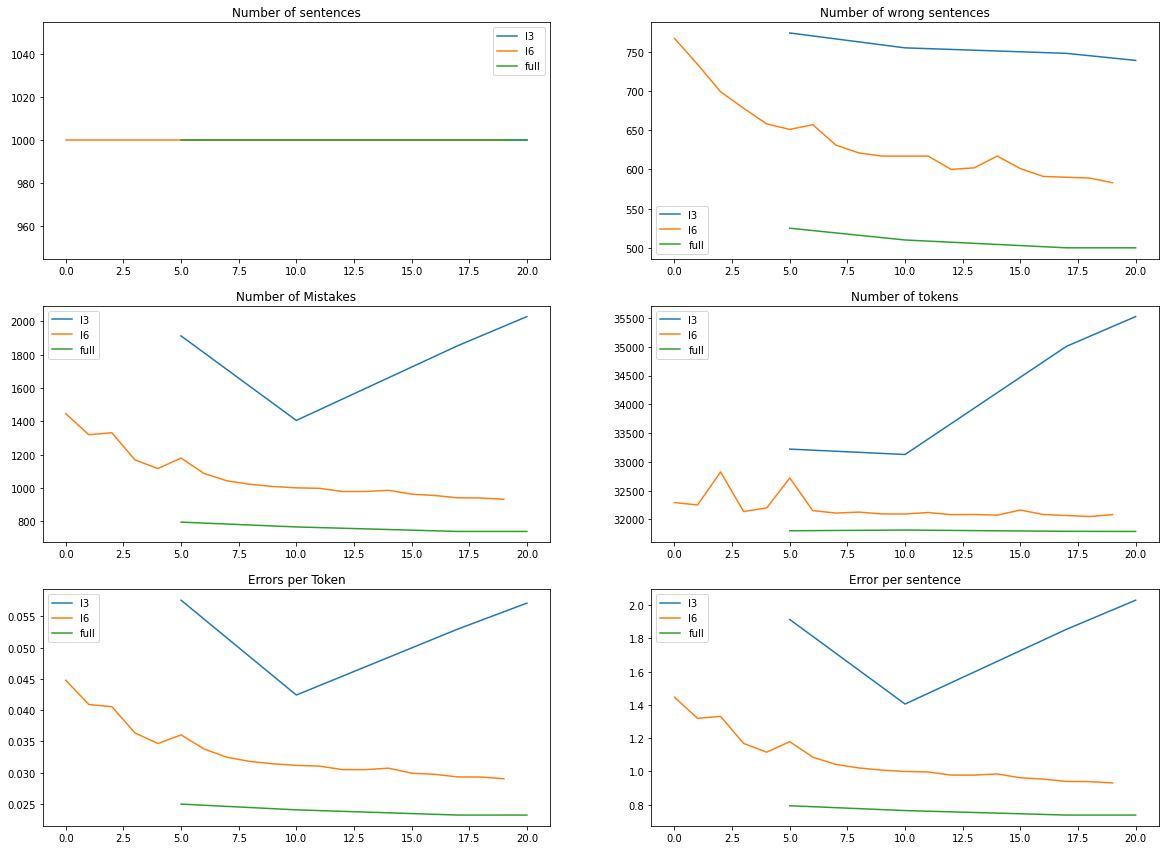

In [58]:
format_reloads_dataset_2(out,0)

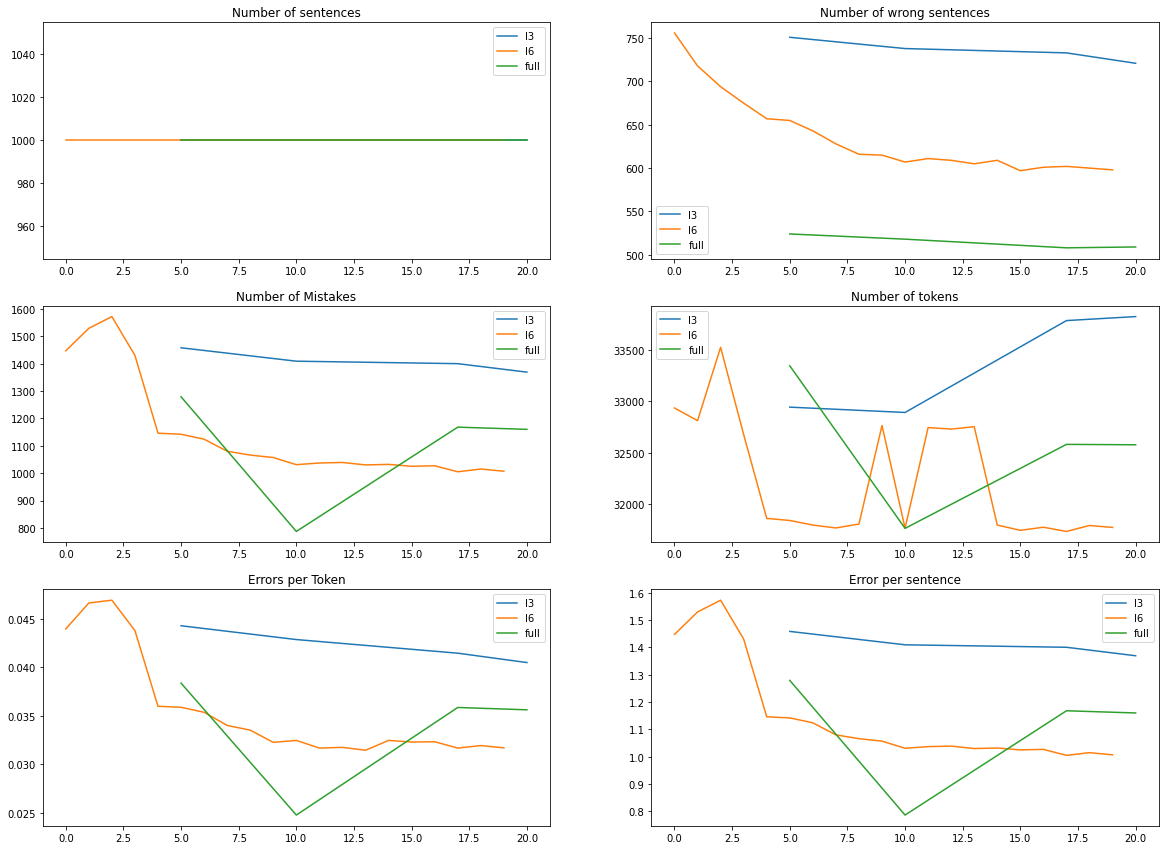

In [59]:
format_reloads_dataset_2(out,1)

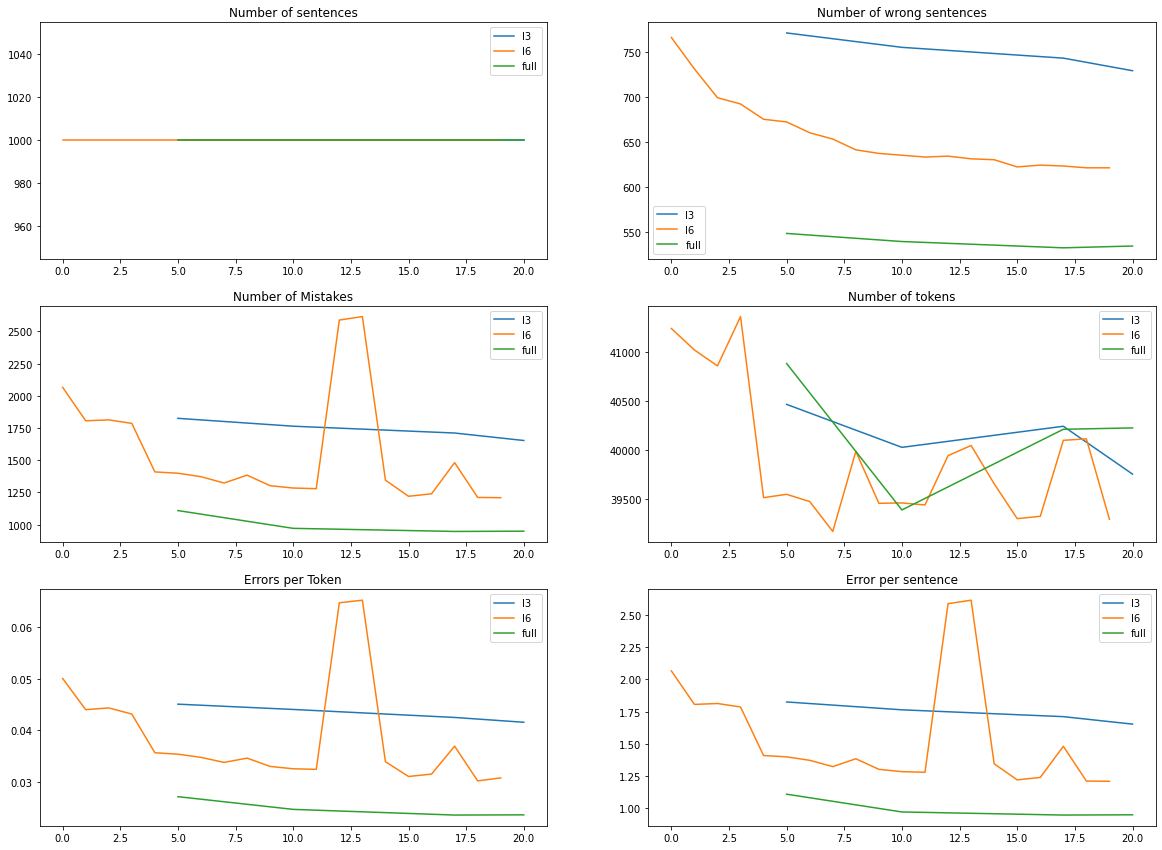

In [60]:
format_reloads_dataset_2(out,2)

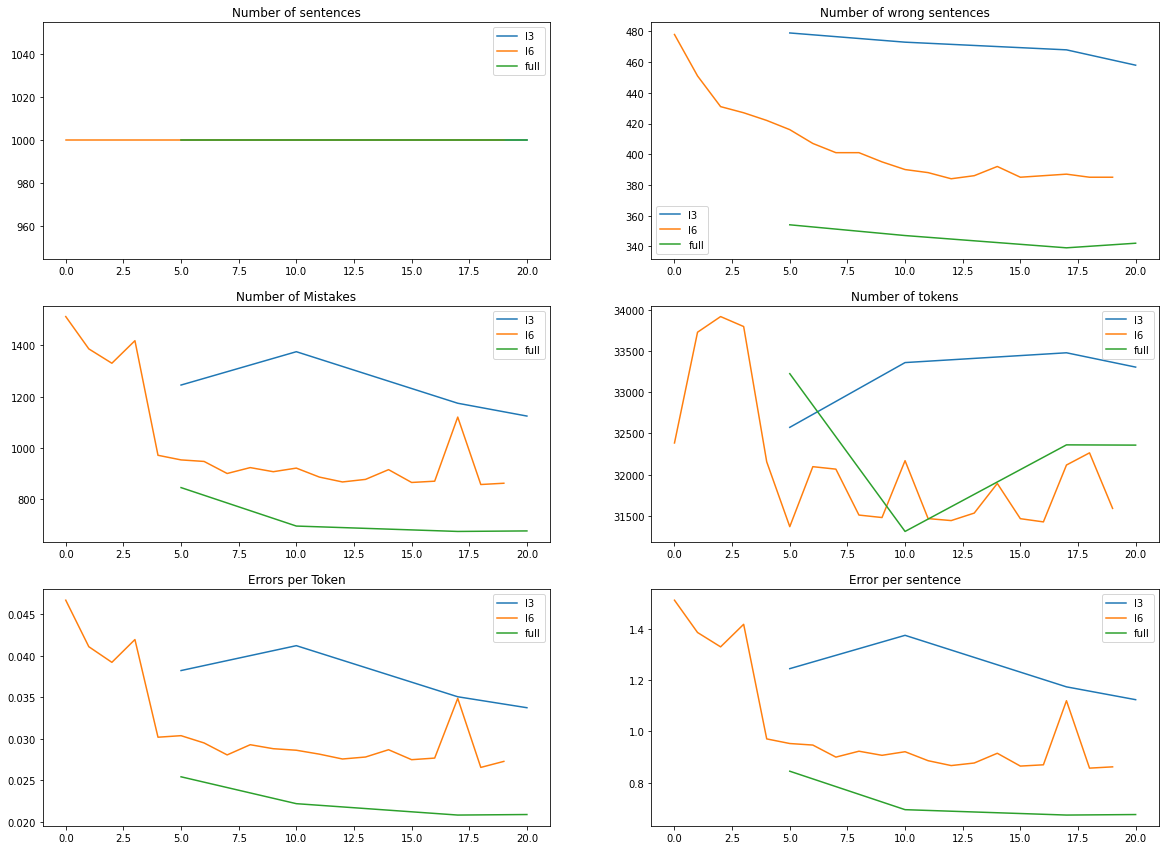

In [61]:
format_reloads_dataset_2(out,3)

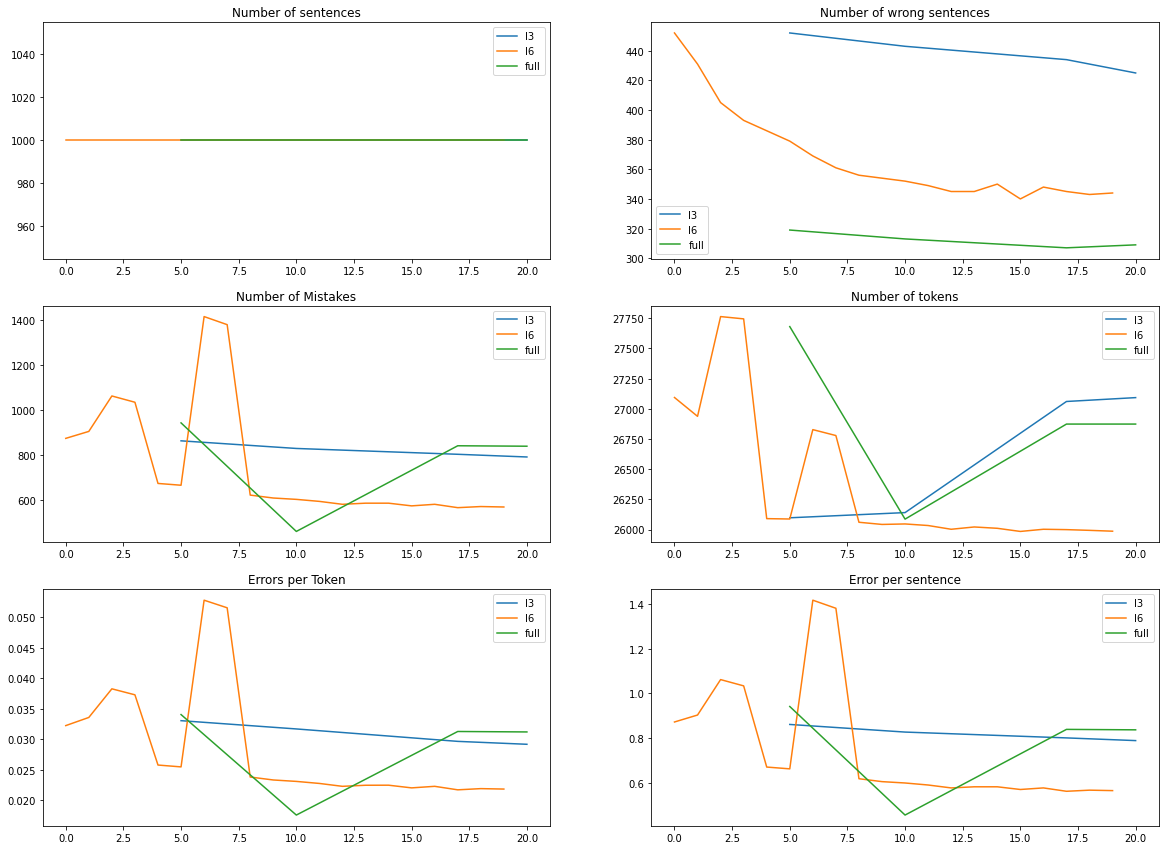

In [62]:
format_reloads_dataset_2(out,4)

# Final comparison 

In [70]:
classic = load_finetune()
classic = np.array(classic)

In [71]:
translation = load_grammar()

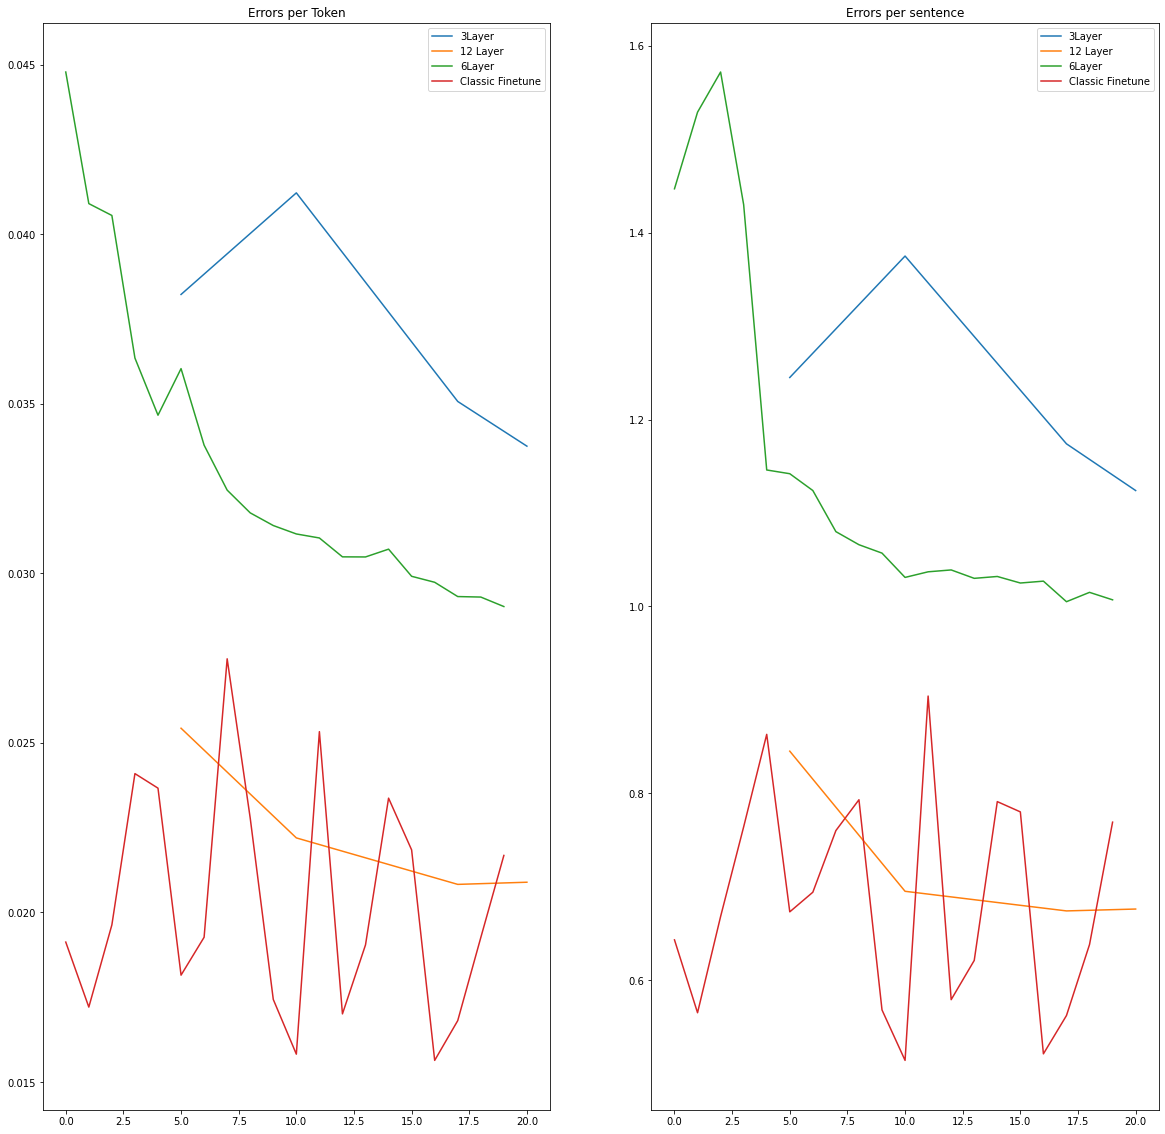

In [72]:
format_reloads_model_3(translation,classic)